In [1]:
# to handle paths
import sys
import os
from pathlib import Path

# to handle datasets
import pandas as pd
import numpy as np
from natsort import natsorted

# for iterating
from itertools import product

# for calculating perfromance 
from sklearn.metrics import mean_absolute_error, median_absolute_error

# for plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns

# for saving
import joblib

# to visualise the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
# variables
project_name = "RF+Clust"
project_folder = f"C:/Users/anani/Downloads/{project_name}"
sys.path.append(project_folder)

from variables import suite_name, features, target, transformation, n_folds, budgets, algorithms
from variables import model_name, explainer_type
from variables import logscale, vmax
from variables import metric, calibration_method, similarity_thresholds, weights_method

In [3]:
# define directories
if features != "all":
    data_folder = f"{project_folder}/Data/{suite_name}/preprocessed/transformation={transformation}_features={features}/{model_name}"
else: 
    data_folder = f"{project_folder}/Data/{suite_name}/preprocessed/transformation={transformation}_features={features}"

results_folder = f"{project_folder}/Results/{suite_name}/transformation={transformation}_features={features}/{model_name}"

In [4]:
def plot_scatter(performance, similarity, logscale, font_scale, figsize, title, results_folder, **kwargs):
    """
    Function to plot a costumized scatterplot.
    """
    # get instances
    instances = similarity.index.tolist()
    print("Instances: ")
    print(instances)
    
    # set up figure
    if suite_name == "bbob":
        sns.set_theme(context='notebook', style='whitegrid', font_scale=font_scale)
        f, axs = plt.subplots(8, 3, figsize=figsize, sharey=True, sharex=False, dpi=80)
        
    elif suite_name == "cec2014":
        sns.set_theme(context='notebook', style='whitegrid', font_scale=font_scale)
        f, axs = plt.subplots(10, 3, figsize=figsize, sharey=True, sharex=False, dpi=80)

    k = 0
    for i in range(axs.shape[0]):
        for j in range(axs.shape[1]):
            print(f"instance: {instances[k]}")        
            
            # get performance of instance of interest
            performance_temp = performance.loc[instances[k], target]
            print(f"performance_temp: {performance_temp}")
            
            # get similarity of instance of interest
            similarity_temp = pd.DataFrame(similarity.loc[instances[k]]).reset_index().rename(columns={"index":"id"})
            similarity_temp = similarity_temp.dropna()
            print(f"similarity_temp:")
            print(similarity_temp.head())
            
            # merge similarity and algorithm performance of other insatnces    
            df_merged = pd.merge(similarity_temp, performance.reset_index(), how='left', on=['id'])
            df_merged = df_merged.rename(columns={instances[k]:'similarity'})
            
            # calculate differernce in performance with instance of interest
            df_merged['difference'] = abs(df_merged[target] - performance_temp)
          
            # plot
            axs[i][j].scatter(df_merged['similarity'], df_merged['difference'], vmin=0, alpha=0.8, s=100)
            
            # enhance plot
            axs[i][j].set_title(f"f_id={instances[k]}")
            axs[i][j].set_xlim(0.4, 1.05)
#             axs[i][j].set_ylim(0, df_merged['difference'].max())
            axs[i][j].set_xticks([0.5, 0.7, 0.9])
            axs[i][j].set_ylabel("difference in algorithm performance")
            axs[i][j].set_xlabel("similarity")
            axs[i][j].yaxis.set_tick_params(labelbottom=True)

            if logscale:
                axs[i][j].set_yscale('log')
                        
            for line in range(0, df_merged.shape[0]):                
                # annotate only the f_id
                axs[i][j].annotate(df_merged['id'].str.split("_").str[0][line], (df_merged.similarity[line] + 0.01, df_merged.difference[line])) #transform=plt.gca().transAxes

            k = k + 1
    
    plt.tight_layout()
    plt.savefig(f"{results_folder}/{title}", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [5]:
def transform_to_pivot(data, values, index):
    """
    Function to transform df to custom pivot.
    """
    pivot = data.copy()
    pivot["id"] = pivot["f_id"].astype(str) + "_" + pivot["i_id"].astype(str) 

    pivot = pivot.drop(["f_id", "i_id"], axis=1)
    pivot = pivot.pivot(index=["model"], columns=["id"], values=values)

    # sort rows and columns
    pivot = pivot.reindex(index)
    pivot = pivot.reindex(natsorted(pivot.columns), axis=1)

    return pivot

In [6]:
def plot_heatmap(data, mask, n_similar, font_scale, figsize, save_path, title, **kwargs):
    """
    Function to plot a costumized heatmap.
    """
    # set up plot
    sns.set_theme(context='notebook', font_scale=font_scale)
    f, axs = plt.subplots(3, 1, figsize=figsize, sharey=False, sharex=False)

    # split f_ids for visualization purposes
    f_id_splits = np.array_split(data.columns.tolist(), 3)
    f_id_splits = [split.tolist() for split in f_id_splits]
    
    # select f_ids
    for i, f_ids in enumerate(f_id_splits):
        print("f_ids: ", f_ids)
             
        data_temp = data[f_ids]  
        mask_temp = mask[f_ids]  
        n_similar_temp = n_similar[f_ids]  
        
        # plot data and mask
        sns.heatmap(data_temp, mask=mask_temp, annot=True, linewidths=3, vmin=0, fmt=''
                    , annot_kws={'va':'bottom', 'rotation': 0}
                    , cbar_kws={'label': 'AE'}, ax = axs[i], **kwargs)
     
        # plot n similar
        sns.heatmap(data_temp, annot=n_similar_temp, mask=mask_temp, linewidths=3, vmin=0, ax = axs[i]
                        , annot_kws={'va':'top', 'rotation': 0}, fmt='', cbar=False, **kwargs)
        
        axs[i].set_ylabel("")
        axs[i].set_ylabel("")
        axs[i].yaxis.set_tick_params(rotation=0)
        
#         for j in range(data_temp.shape[0]):
#             heatmap.axhline(j, color='white', lw=3)

    f.supxlabel('f_id')
    f.title = (title)
    
    plt.tight_layout()
    plt.savefig(f"{save_path}/{title}.png", bbox_inches='tight', dpi=300)

    plt.show()
    plt.close()

## RF+Clus Analysis

### Algorithm performance vs similarity

algorithm_name: DE1, budget: 5000
performance: 
     log_precision
id                
1_1       6.571792
2_1       7.314740
3_1       3.507980
4_1       1.574784
5_1       1.329654
          2_1       3_1       4_1       5_1       6_1       7_1       8_1  \
id                                                                          
1_1  0.350648  0.231432  0.410653 -0.569528 -0.698991  0.355225 -0.093454   
2_1       NaN  0.087106  0.026450 -0.225486 -0.227472  0.063930  0.015541   
3_1 -0.318424       NaN -0.409551  0.108208 -0.097299 -0.565689 -0.747727   
4_1  0.440612 -0.439765       NaN -0.739087 -0.605895  0.901391  0.531624   
5_1 -0.517650  0.124947 -0.722758       NaN  0.936521 -0.682488 -0.197509   

          9_1      10_1      11_1      12_1      13_1      14_1      15_1  \
id                                                                          
1_1 -0.151571 -0.523817 -0.521775 -0.570228  0.319764  0.114035 -0.063842   
2_1  0.004238 -0.225889 -0.219314 -0.227323  0.0

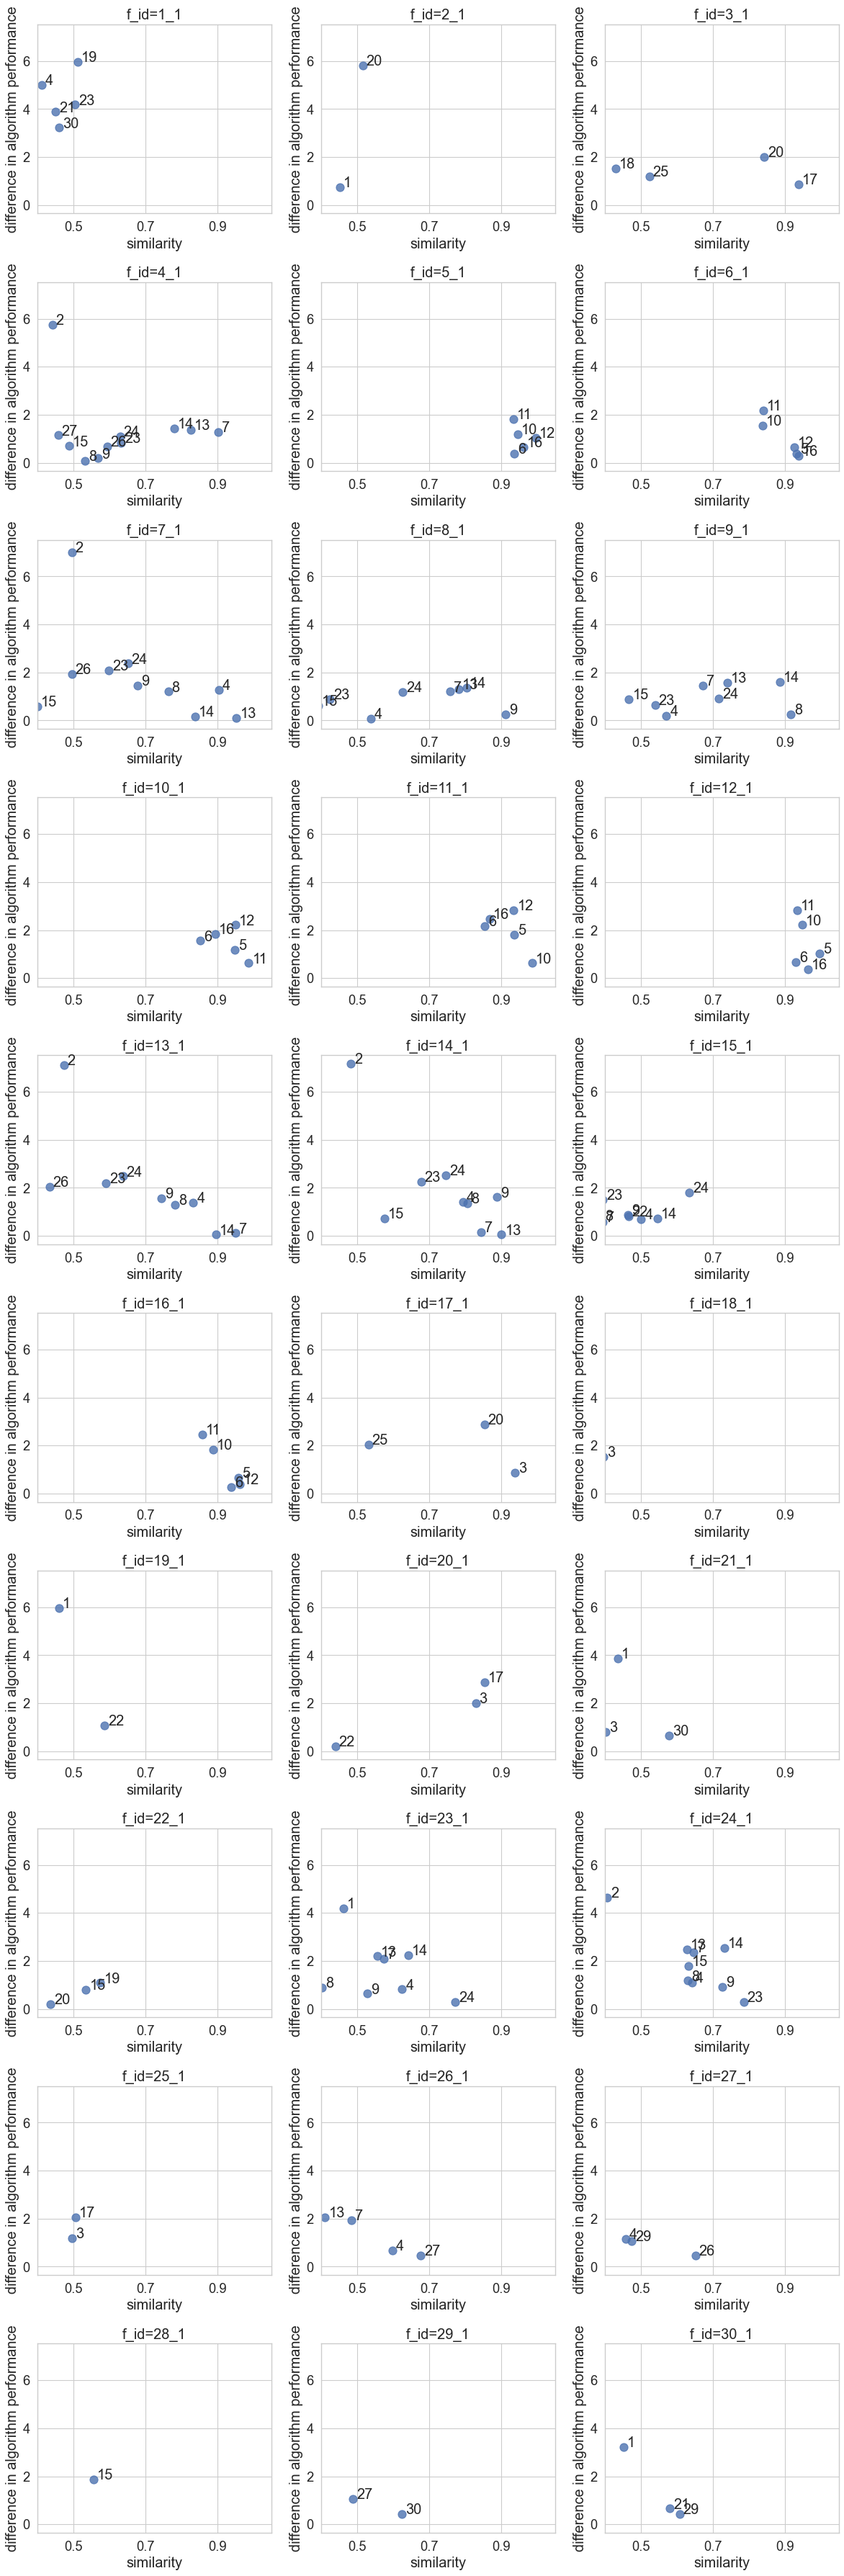

algorithm_name: DE2, budget: 5000
performance: 
     log_precision
id                
1_1       6.387609
2_1       8.313207
3_1       4.049995
4_1       2.082121
5_1       1.331752
          2_1       3_1       4_1       5_1       6_1       7_1       8_1  \
id                                                                          
1_1  0.350648  0.231432  0.410653 -0.569528 -0.698991  0.355225 -0.093454   
2_1       NaN  0.087106  0.026450 -0.225486 -0.227472  0.063930  0.015541   
3_1 -0.318424       NaN -0.409551  0.108208 -0.097299 -0.565689 -0.747727   
4_1  0.440612 -0.439765       NaN -0.739087 -0.605895  0.901391  0.531624   
5_1 -0.517650  0.124947 -0.722758       NaN  0.936521 -0.682488 -0.197509   

          9_1      10_1      11_1      12_1      13_1      14_1      15_1  \
id                                                                          
1_1 -0.151571 -0.523817 -0.521775 -0.570228  0.319764  0.114035 -0.063842   
2_1  0.004238 -0.225889 -0.219314 -0.227323  0.0

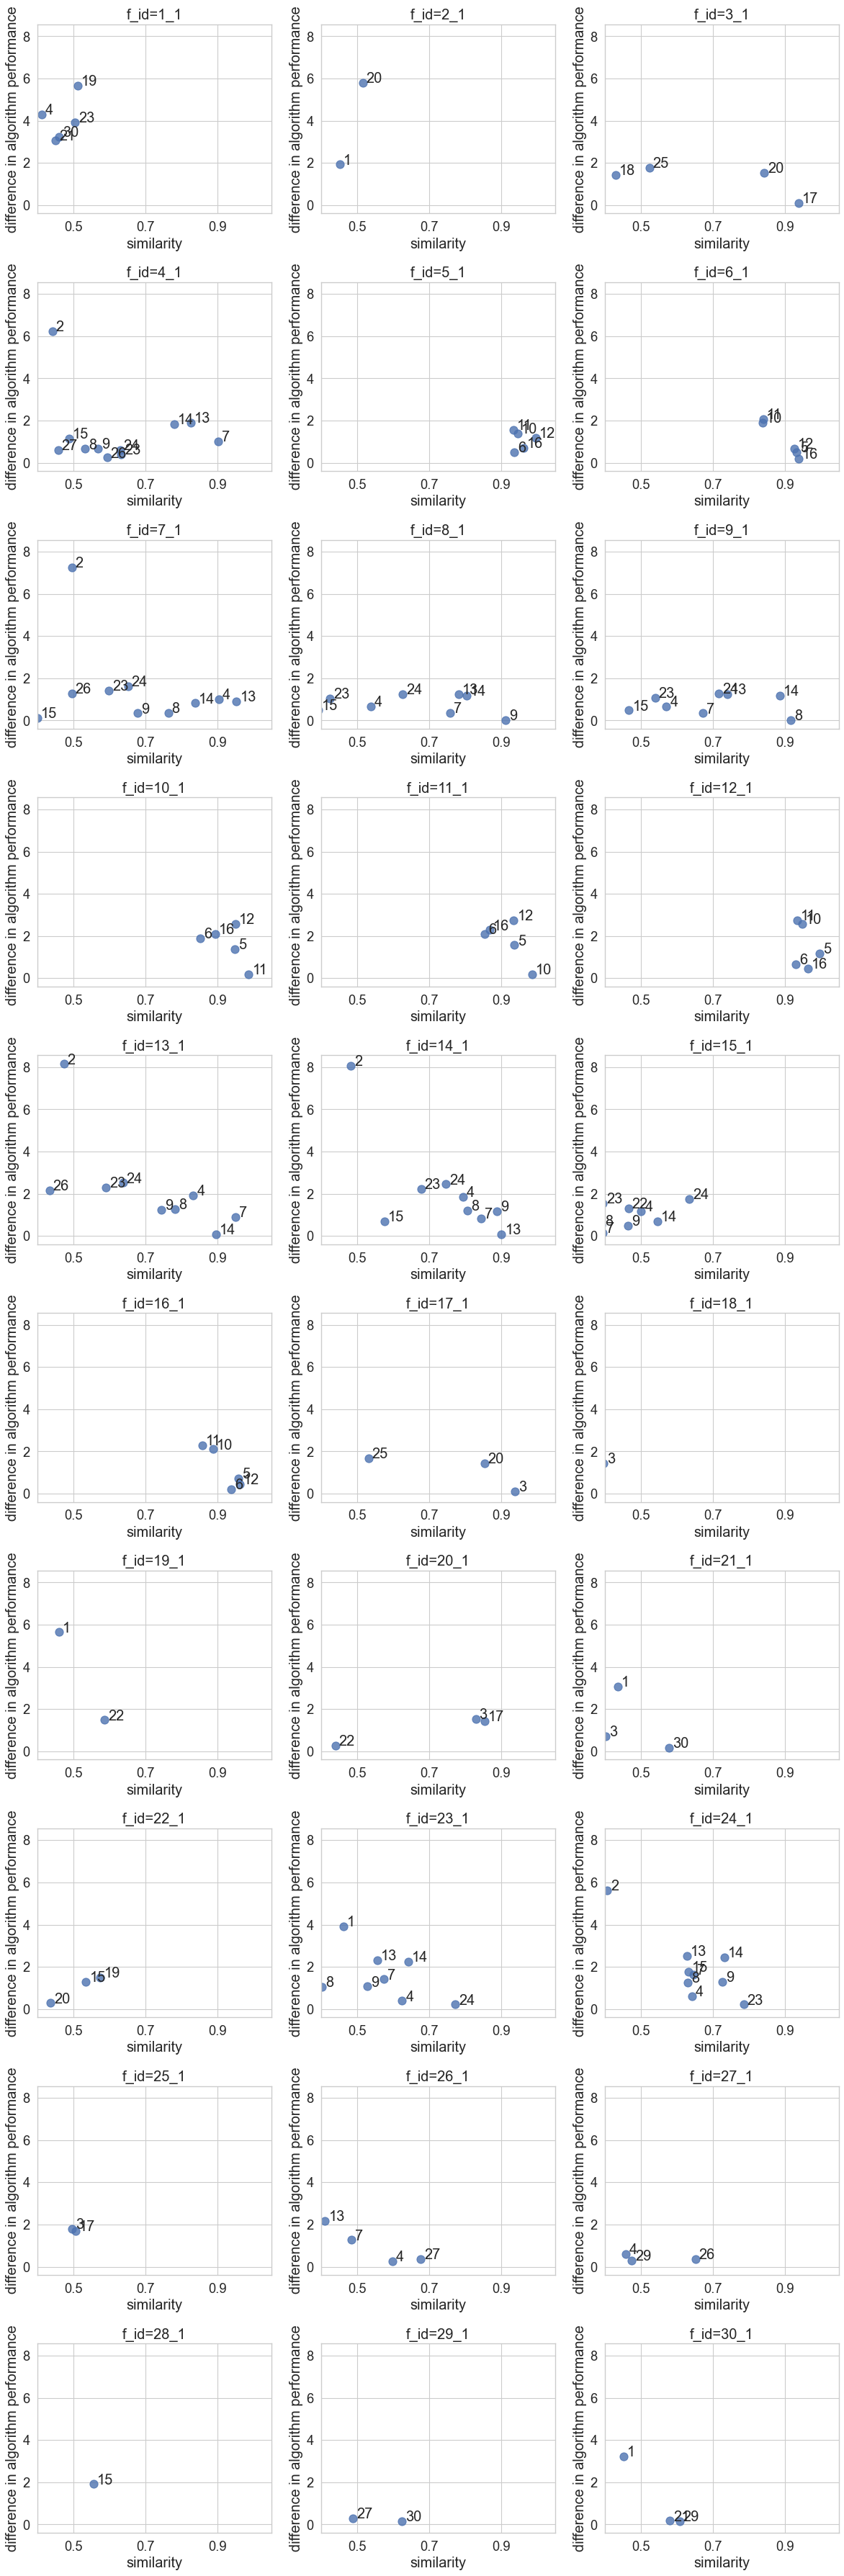

algorithm_name: DE3, budget: 5000
performance: 
     log_precision
id                
1_1       5.295018
2_1       3.308920
3_1       1.973953
4_1       1.553644
5_1       1.329271
          2_1       3_1       4_1       5_1       6_1       7_1       8_1  \
id                                                                          
1_1  0.350648  0.231432  0.410653 -0.569528 -0.698991  0.355225 -0.093454   
2_1       NaN  0.087106  0.026450 -0.225486 -0.227472  0.063930  0.015541   
3_1 -0.318424       NaN -0.409551  0.108208 -0.097299 -0.565689 -0.747727   
4_1  0.440612 -0.439765       NaN -0.739087 -0.605895  0.901391  0.531624   
5_1 -0.517650  0.124947 -0.722758       NaN  0.936521 -0.682488 -0.197509   

          9_1      10_1      11_1      12_1      13_1      14_1      15_1  \
id                                                                          
1_1 -0.151571 -0.523817 -0.521775 -0.570228  0.319764  0.114035 -0.063842   
2_1  0.004238 -0.225889 -0.219314 -0.227323  0.0

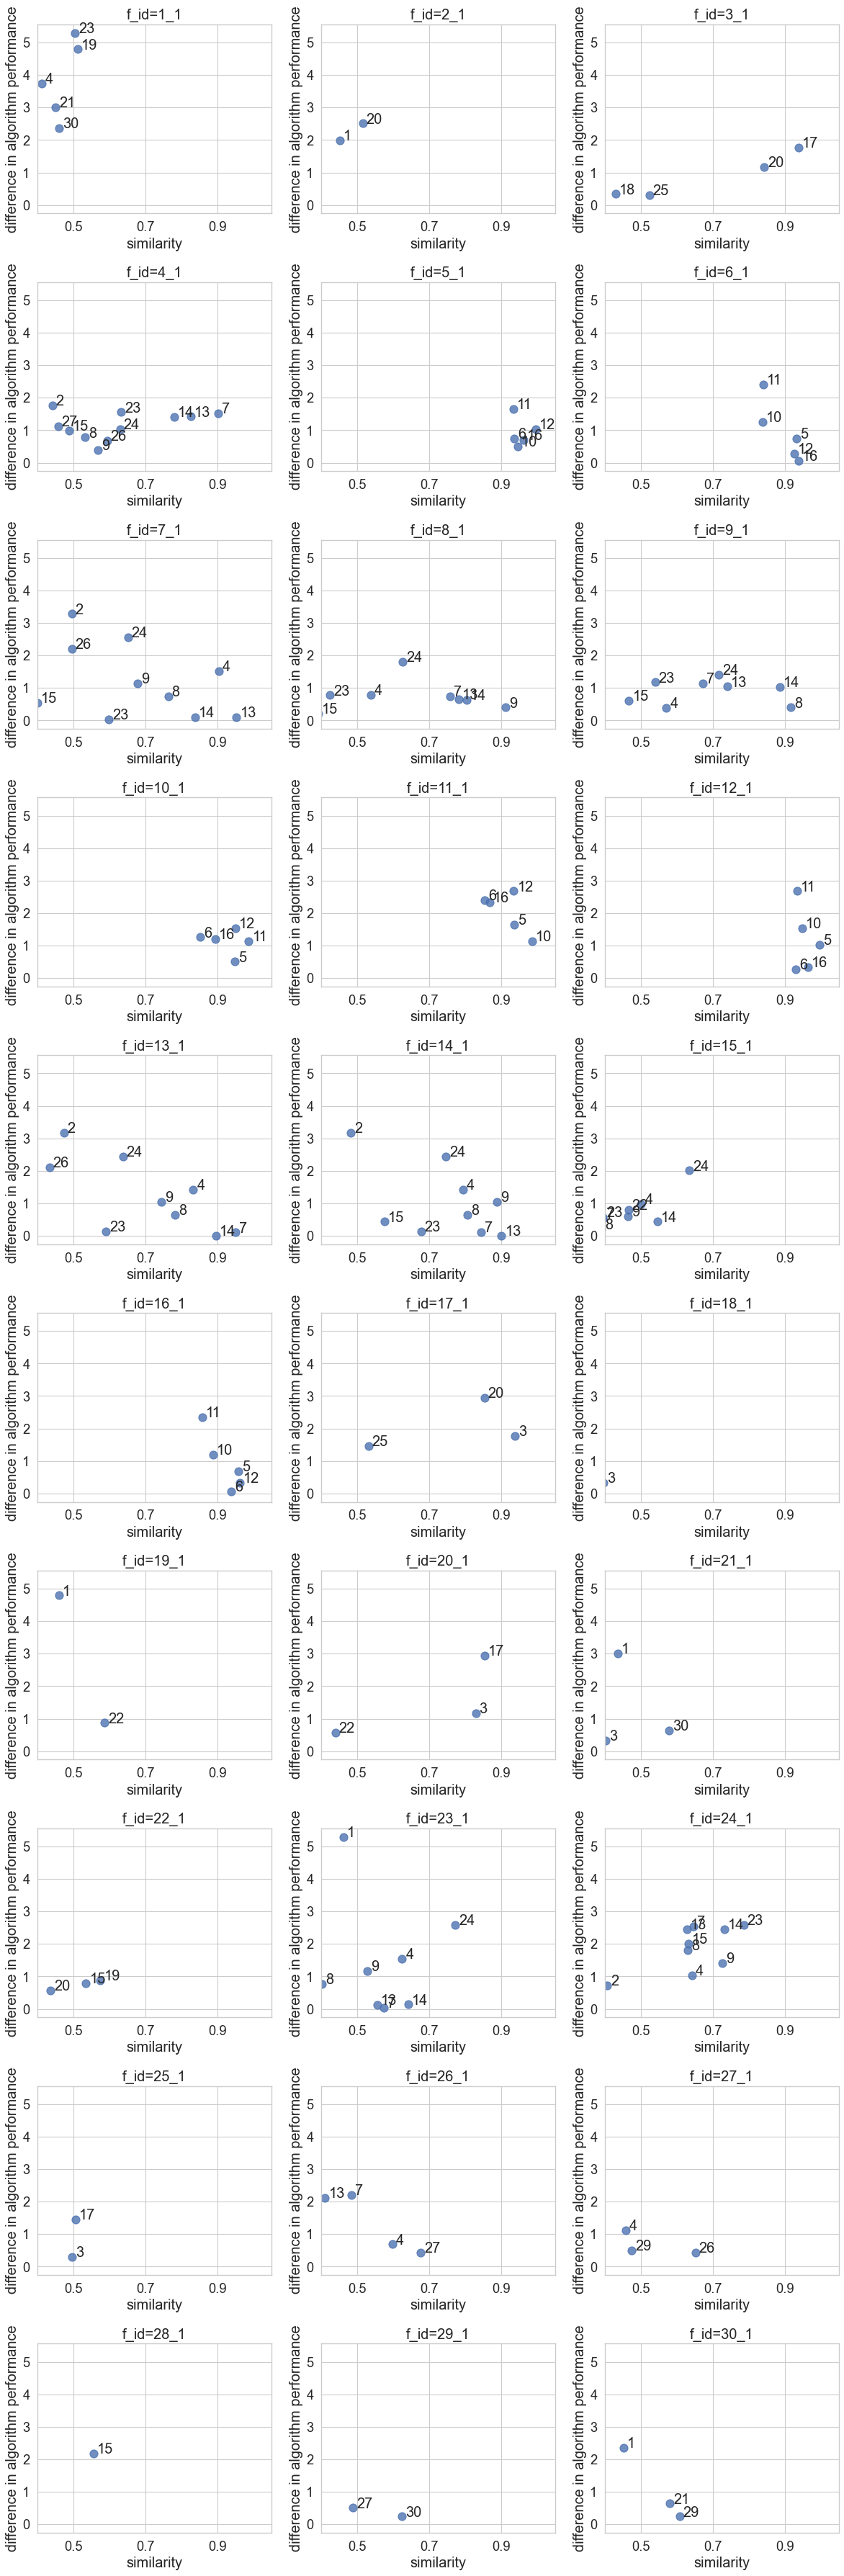

In [7]:
for algorithm_name, budget in product(algorithms, budgets):
    print(f"algorithm_name: {algorithm_name}, budget: {budget}")
    
    # define directories
    results_folder_temp = f"{results_folder}/algorithm_name={algorithm_name}_budget={budget}"
    dataset_folder = f"{project_folder}/Data/{suite_name}/original/dataset"

    # load algorithm performance
    performance = pd.read_csv(f"{dataset_folder}/algorithm_name={algorithm_name}_budget={budget}_dataset.csv"
                              , dtype={"f_id":str, "i_id":str})
    
    performance["id"] = performance["f_id"].astype(str) + "_" + performance["i_id"].astype(str) 

    performance = performance.drop(["f_id", "i_id"], axis=1)
    performance = performance.set_index("id")
    performance = pd.DataFrame(performance[target])
    print("performance: ")
    print(performance.head())
    
    # load similarity
    title = f"metric={metric}_threshold=0.5_method={calibration_method}_weights={weights_method}"
    similarity = pd.read_csv(f"{results_folder_temp}/rfclust/similarity_{title}.csv")
    similarity["id"] = similarity["f_id"].astype(str) + "_" + similarity["i_id"].astype(str) 

    similarity = similarity.drop(["f_id", "i_id"], axis=1)
    similarity = similarity.set_index("id")
    print(similarity.head())
    
    # plot similarity vs difference in performance
    plot_scatter(performance=performance, similarity=similarity, logscale=logscale, font_scale=1.5, figsize=(15, 45)
                 ,title=f"sm_vs_{target}_metric={metric}_weights={weights_method}", results_folder=f"{results_folder_temp}/rfclust")

### Heatmaps of ML error

algorithm_name: DE1
budget: 5000
similarity_threshold: 0.5
similarity_threshold: 0.7
similarity_threshold: 0.9
   f_id  i_id      true  predicted model
0     1     1  6.571792   3.001946    RF
1     2     1  7.314740   1.050347    RF
2     3     1  3.507980   2.772691    RF
3     4     1  1.574784   1.319617    RF
4     5     1  1.329654   1.264743    RF
5     6     1  0.960499   1.403826    RF
6     7     1  0.306322   1.797833    RF
7     8     1  1.503573   1.172140    RF
8     9     1  1.758036   1.330792    RF
9    10     1  2.513509   2.194232    RF
ae: 
id          1_1       2_1       3_1       4_1       5_1       6_1       7_1  \
model                                                                         
RF     3.569846  6.264393  0.735289  0.255166  0.064912  0.443327  1.491511   
0.9    3.569846  6.264393  0.062211  0.761814  0.052803  0.126509  1.026131   
0.7    3.569846  6.264393  0.618589  0.804515  0.052803  0.512301  1.009292   
0.5    4.323971  6.043726  0.696135  0

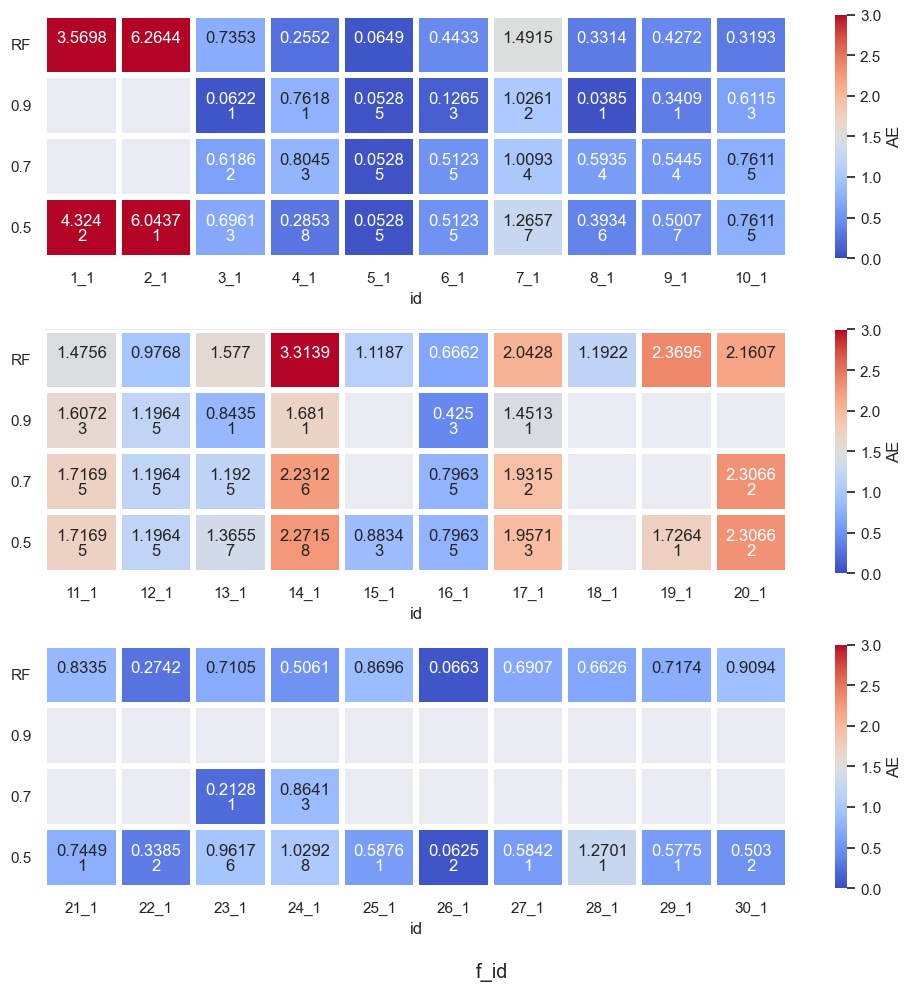

Preview summary performance for DE1: 
     times_better  times_equal  times_worse
RF            NaN          NaN          NaN
0.9          10.0         16.0          4.0
0.7           7.0         13.0         10.0
0.5          15.0          1.0         14.0
algorithm_name: DE2
budget: 5000
similarity_threshold: 0.5
similarity_threshold: 0.7
similarity_threshold: 0.9
   f_id  i_id      true  predicted model
0     1     1  6.387609   2.883428    RF
1     2     1  8.313207   1.793079    RF
2     3     1  4.049995   3.154913    RF
3     4     1  2.082121   1.960479    RF
4     5     1  1.331752   0.869940    RF
5     6     1  0.816515   1.169986    RF
6     7     1  1.059685   1.761457    RF
7     8     1  1.426913   0.931171    RF
8     9     1  1.402696   1.074371    RF
9    10     1  2.717377   2.114559    RF
ae: 
id          1_1       2_1       3_1       4_1       5_1       6_1       7_1  \
model                                                                         
RF     3.504181  

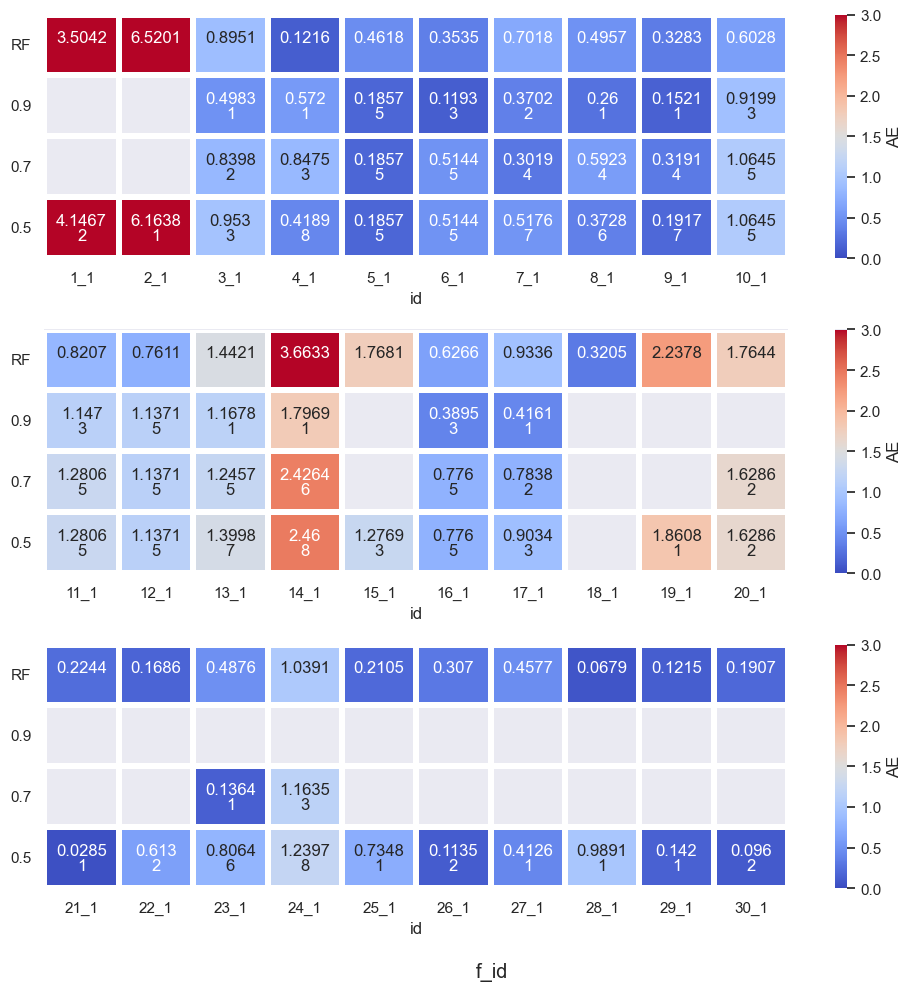

Preview summary performance for DE2: 
     times_better  times_equal  times_worse
RF            NaN          NaN          NaN
0.9          10.0         16.0          4.0
0.7           9.0         13.0          8.0
0.5          15.0          1.0         14.0
algorithm_name: DE3
budget: 5000
similarity_threshold: 0.5
similarity_threshold: 0.7
similarity_threshold: 0.9
   f_id  i_id      true  predicted model
0     1     1  5.295018   2.004364    RF
1     2     1  3.308920   0.863802    RF
2     3     1  1.973953   2.231251    RF
3     4     1  1.553644   1.347469    RF
4     5     1  1.329271   0.957202    RF
5     6     1  0.577003   1.777425    RF
6     7     1  0.031472   1.581840    RF
7     8     1  0.776323   0.685779    RF
8     9     1  1.173031   0.701530    RF
9    10     1  1.835061   1.840049    RF
ae: 
id          1_1       2_1       3_1       4_1      5_1       6_1       7_1  \
model                                                                        
RF     3.290654  2.

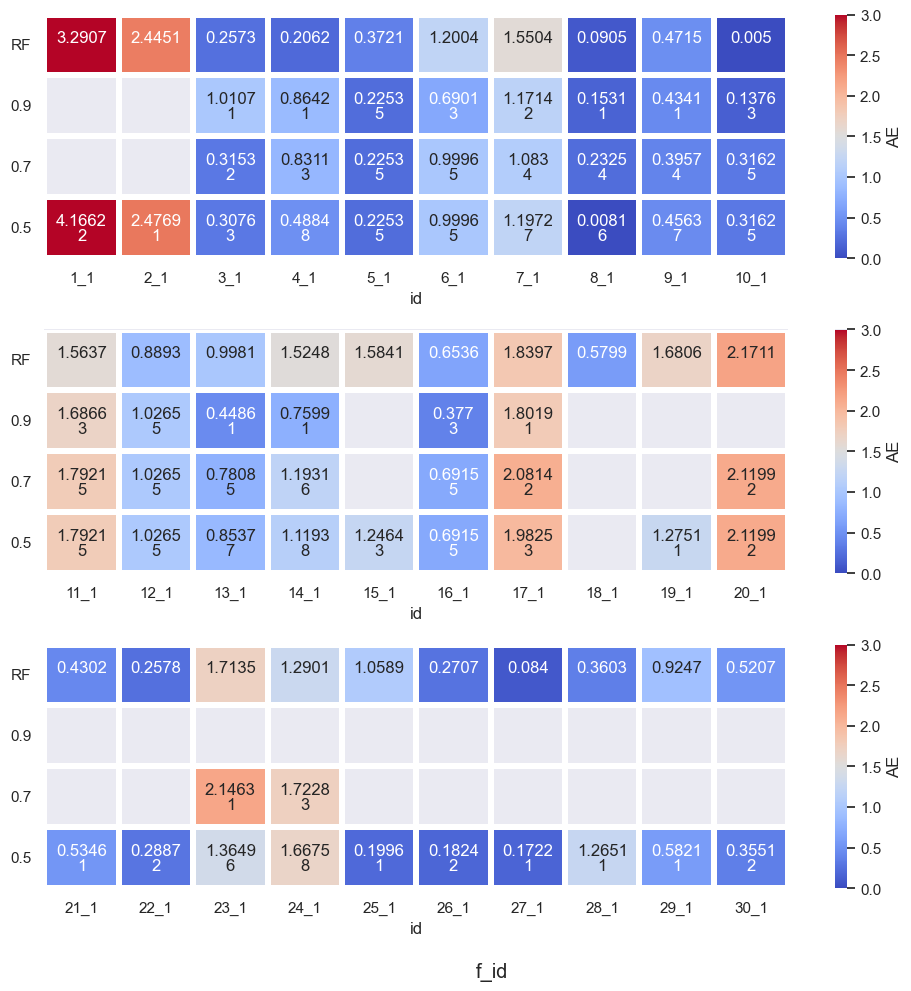

Preview summary performance for DE3: 
     times_better  times_equal  times_worse
RF            NaN          NaN          NaN
0.9           8.0         16.0          6.0
0.7           7.0         13.0         10.0
0.5          15.0          1.0         14.0


In [8]:
for algorithm_name, budget in product(algorithms, budgets):
    print(f"algorithm_name: {algorithm_name}")
    print(f"budget: {budget}")
    
    # define directories
    data_folder_temp = f"{data_folder}/algorithm_name={algorithm_name}_budget={budget}"
    results_folder_temp = f"{results_folder}/algorithm_name={algorithm_name}_budget={budget}"
    # file title
    title = f"metric={metric}_method={calibration_method}_weights={weights_method}"

    # create results placeholders
    ae = pd.read_csv(f"{results_folder_temp}/predictions/predictions_set=test.csv")
    ae["model"] = "RF"
    
    mask = pd.DataFrame(ae[["f_id", "i_id"]])
    mask["model"] = "RF"
    mask["predicted"] = False
    
    n_similar = pd.DataFrame(ae[["f_id", "i_id"]])
    n_similar["model"] = "RF"
    n_similar["n_similar"] = " "
    
    for similarity_threshold in similarity_thresholds:
        print(f"similarity_threshold: {similarity_threshold}")

        # load data
        title = f"metric={metric}_threshold={similarity_threshold}_method={calibration_method}_weights={weights_method}"
        
        # ae
        ae_temp = pd.read_csv(f"{results_folder_temp}/rfclust/predictions_{title}.csv")
        ae_temp["model"] = similarity_threshold   
        ae = pd.concat([ae, ae_temp], axis=0)
        
        # mask
        mask_temp = pd.read_csv(f"{results_folder_temp}/rfclust/mask_{title}.csv")
        mask_temp["model"] = similarity_threshold
        mask = pd.concat([mask, mask_temp], axis=0)
        
        # similar instances
        n_similar_temp = pd.read_csv(f"{results_folder_temp}/rfclust/similar_instances_{title}.csv")
        n_similar_temp['n_similar'] = n_similar_temp["similar_instances"].apply(lambda x: len(x.split("),")))
        n_similar_temp = n_similar_temp.drop("similar_instances", axis=1)      
        n_similar_temp["model"] = similarity_threshold
        n_similar = pd.concat([n_similar, n_similar_temp], axis=0)        
    
    # ae
    print(ae.head(10))
    ae["AE"] =  abs(ae["true"] - ae["predicted"])
    ae = transform_to_pivot(ae, values="AE", index=["RF"]+[0.9, 0.7, 0.5])
    print("ae: ")
    print(ae)
    ae.reset_index().to_csv(f"{results_folder_temp}/rfclust/ae_compare_models_features={features}.csv", index=False)
    
    # mask
    mask = transform_to_pivot(mask, values="predicted", index=["RF"]+[0.9, 0.7, 0.5])
    print("mask: ")
    print(mask)
   
    # similar instances
    n_similar = transform_to_pivot(n_similar, values="n_similar", index=["RF"]+[0.9, 0.7, 0.5])
    print(f"similar_instances: ")
    print(n_similar)
    
    # for visualization purposes only
    if suite_name == "bbob":
        columns = ae.columns
        columns = [col for col in columns if col.split("_")[1] == "1"]
        
        ae = ae[columns]
        mask = mask[columns]
        n_similar = n_similar[columns]
        
    # plot heatmap
    plot_heatmap(data=round(ae, 4), mask=mask, n_similar=n_similar, font_scale=1, figsize=(10,10)
                 , save_path=f"{results_folder_temp}/rfclust"
                 , title=f"compare_models_{title}", cmap="coolwarm", vmax=3)      